In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

In [ ]:
img = cv2.imread('raw_datacollection_B9/indians/indian-197.jpg')

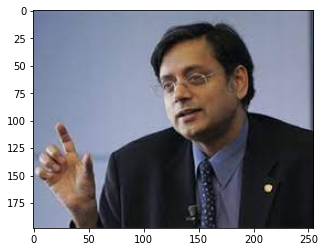

In [ ]:
img_show = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_show)
plt.show()

In [ ]:
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_eye.xml')
nose_cascade = cv2.CascadeClassifier('haarcascades/Nariz.xml')

In [ ]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color
def get_cropped_image_color(img):
    #img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    nose = nose_cascade.detectMultiScale(gray)
    for (x,y,w,h) in nose:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        return roi_color

In [ ]:
img_dirs = []
path_data = 'raw_datacollection_B9/'
for entry in os.scandir(path_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [ ]:
img_dirs

['raw_datacollection_B9/foreigners', 'raw_datacollection_B9/indians']

In [ ]:
import shutil
path_cropped = 'cropped/'
if os.path.exists(path_cropped):
    shutil.rmtree(path_cropped)
os.mkdir(path_cropped)

In [ ]:
cropped_image_dirs = []
humans_file_names_dict = {}
for img_dir in img_dirs:
    count = 1
    human_type = img_dir.split('/')[-1]
    print(human_type)
    
    humans_file_names_dict[human_type] = []
    
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_cropped + human_type
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
                
            cropped_file_name = human_type + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name 
            
            cv2.imwrite(cropped_file_path, roi_color)
            humans_file_names_dict[human_type].append(cropped_file_path)
            count += 1    

foreigners
Generating cropped images in folder:  cropped/foreigners
indians
Generating cropped images in folder:  cropped/indians


In [ ]:
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

In [ ]:
class_dict = {}
count = 0
for human_type in humans_file_names_dict.keys():
    class_dict[human_type] = count
    count = count + 1
class_dict

{'foreigners': 0, 'indians': 1}

In [ ]:
# img = cv2.imread('cropped/indians/indians107.png')
# scalled_raw_img = cv2.resize(img, (32, 32))
# img_har = w2d(img,'db1',5)
# scalled_img_har = cv2.resize(img_har, (32, 32))
# col_feature = get_cropped_image_color(img)
# scalled_col_feature = cv2.resize(col_feature, (32, 32))
# combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),
#                           scalled_img_har.reshape(32*32,1),
#                           scalled_col_feature.reshape(32*32*3,1)))

In [ ]:
X, y = [], []
for human_type, training_files in humans_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        try:
            scalled_raw_img = cv2.resize(img, (32, 32))
            img_har = w2d(img,'db1',5)
            col_feature = get_cropped_image_color(img)
            scalled_col_feature = cv2.resize(col_feature, (32, 32))
            scalled_img_har = cv2.resize(img_har, (32, 32))
            combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),
                                      scalled_img_har.reshape(32*32,1),
                                      scalled_col_feature.reshape(32*32*3,1)))
        except Exception as e:
            pass
        X.append(combined_img)
        y.append(class_dict[human_type])     

In [ ]:
X = np.array(X).reshape(len(X),len(X[0])).astype(float)

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [ ]:
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.8333333333333334

In [ ]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.81      0.86      0.84       132
           1       0.85      0.80      0.83       132

    accuracy                           0.83       264
   macro avg       0.83      0.83      0.83       264
weighted avg       0.83      0.83      0.83       264



In [ ]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [ ]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [8,9,10,11,15,20],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,2,3,4,5]
        }
    }
}

In [ ]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.819465,"{'svc__C': 8, 'svc__kernel': 'rbf'}"
1,logistic_regression,0.815620,{'logisticregression__C': 3}


In [ ]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc', SVC(C=8, gamma='auto', probability=True))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=3, solver='liblinear'))])}

In [ ]:
best_estimators['svm'].score(X_test,y_test)

0.8333333333333334

In [ ]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.8371212121212122

In [ ]:
best_clf = best_estimators['svm']

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[114,  18],
       [ 26, 106]])

Text(69.0, 0.5, 'Truth')

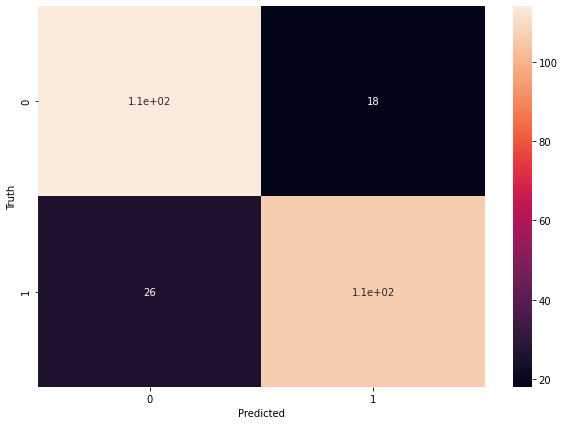

In [ ]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
import joblib

In [ ]:
joblib.dump(best_clf, 'indian_foreign_svm.pkl')

['indian_foreign_svm.pkl']